In [11]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import pandas as pd

In [13]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
    # Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [15]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [16]:
    # Reflect an existing database into a new model
Base = automap_base()
    # Reflect the tables
Base.prepare(engine, reflect=True)

In [17]:
    # We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
    # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [19]:
    # Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

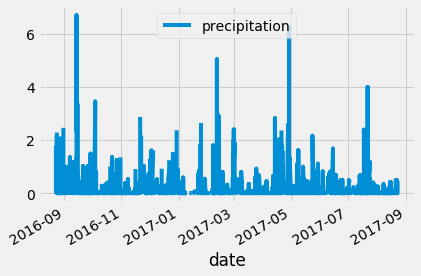

In [21]:
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

max_date = max_date[0]

year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)

da_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

precip_df = pd.DataFrame(da_query,columns=['date', 'precipitation'])

precip_df['date'] = pd.to_datetime(precip_df['date'], format='%Y-%m-%d')

precip_df.set_index('date', inplace=True)
    
precip_df = precip_df.sort_values(by='date',ascending=True)

precip_df .plot(title="")
plt.legend(loc='upper center')
plt.savefig("Images/1_Precipitation.png")
plt.show()

In [22]:
    # Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
    # how many stations?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Stations Available: {available_stations} ")

Stations Available: 9 


In [24]:
    # most active stations? 
    # List the stations and the counts in descending order.
    
active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"------------------------")
print(f" Most Active Stations")
print(f"------------------------")
active_stations

------------------------
 Most Active Stations
------------------------


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
    # Finding most active station 
most_active_station=active_stations[0][0]
print(f"Most Active Station: {most_active_station}")

Most Active Station: USC00519281


In [26]:
    # Using the station id from the previous query, calculate the lowest temperature recorded, 
    # Highest temperature recorded, and average temperature most active station?
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"------------------------------------")
print(f" Most Active Station Temperatures")
print(f"------------------------------------")
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")

------------------------------------
 Most Active Station Temperatures
------------------------------------
Low: 54.0 High: 85.0 Average: 71.7


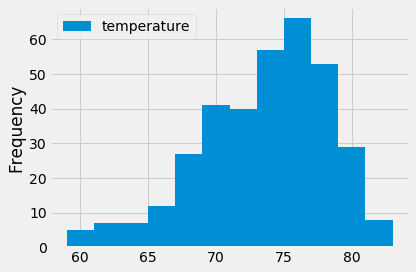

In [27]:
    # Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]

    # Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['temperature'])

    # Choose 12 bins sizes in statistics for histograms 
temperature_observations.plot.hist(bins=12, title="")
plt.tight_layout()
plt.savefig("Images/2_TemperaturevsFrequency.png")
plt.show()

In [39]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [37]:
    # Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
    # for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-08-01','2017-08-14')
trip

[(71.0, 79.01785714285714, 84.0)]

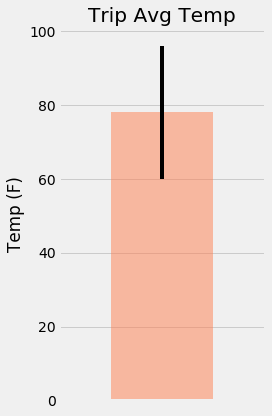

In [30]:
    # Create a dataframe for tmin, tavg, and tmax values
trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

    # Plot the results from your previous query as a bar chart.     
trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/3_TripAvgTemp.png")
plt.show()

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-07-01','2017-07-14'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.1), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.08), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None)]
